In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..', '..'))
sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
kb = con.physical_constants['Boltzmann constant in eV/K'][0]

import scipy.integrate as int

import scipy.io as sio

import scipy.optimize as opt

from misloc_mispol_package.parameterize import displaced_osc_model as dom


In [4]:
## This needs to be in a seperate cell from the imports
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 300,  # to adjust notebook inline plot size
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
#     'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4, 3], # 4 x 3
    'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100
}
mpl.rcParams.update(params)


Text(0.5, 0, 'Photon Energy $\\hbar\\omega$ [eV]')

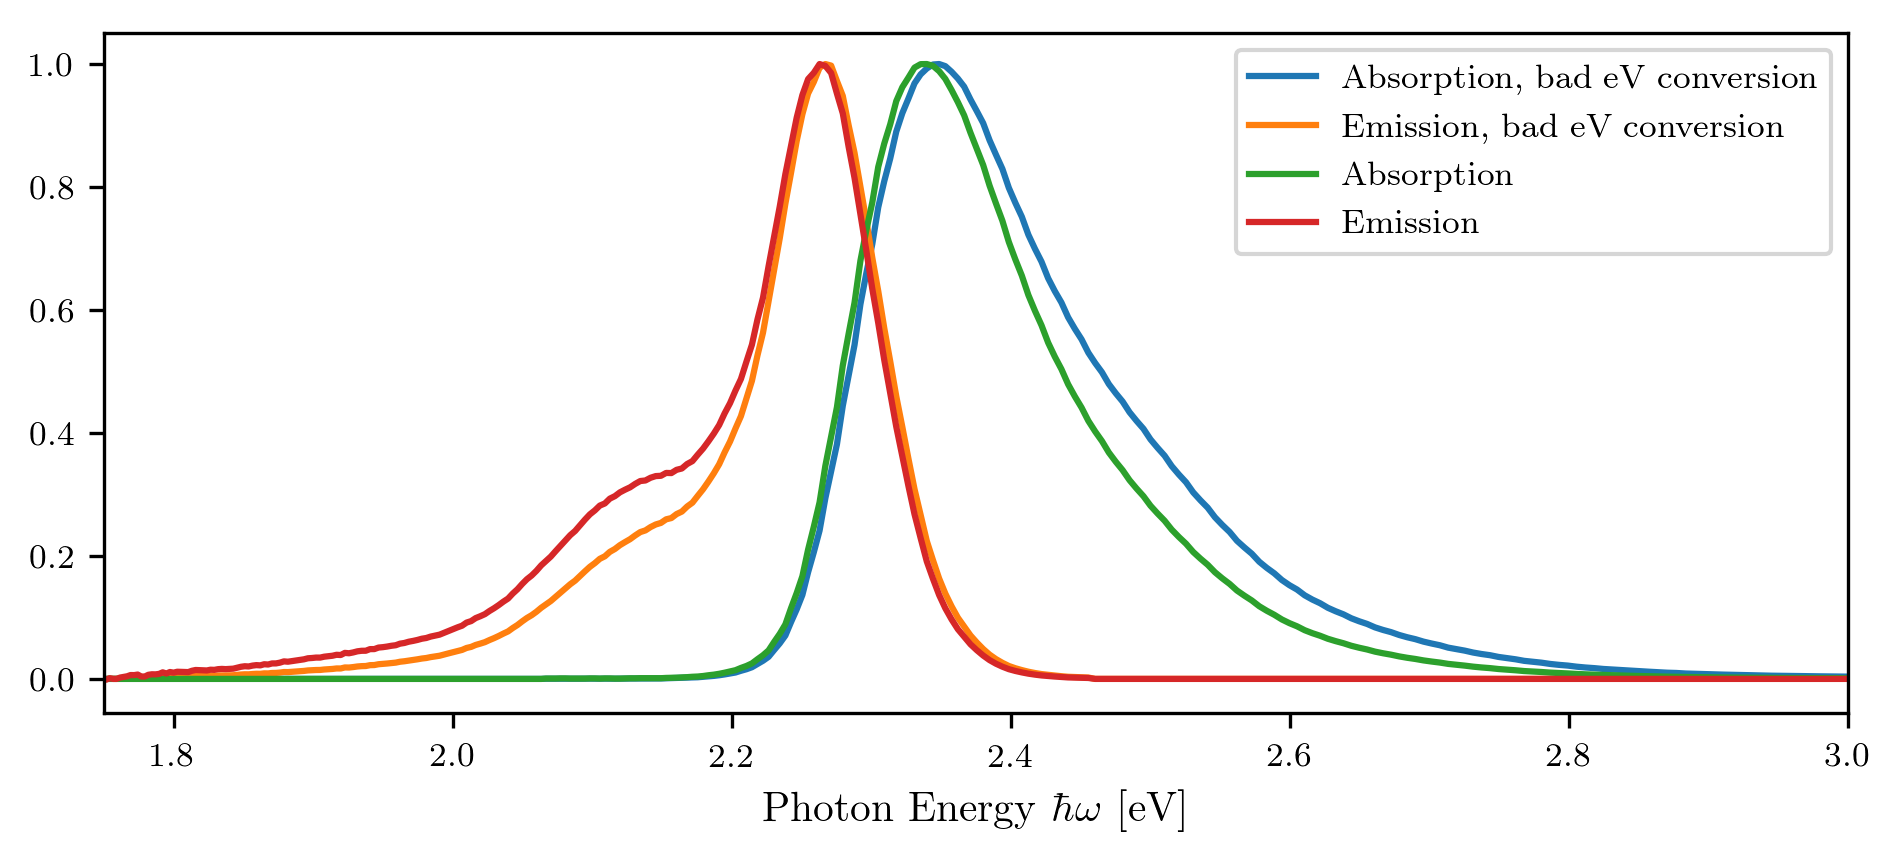

In [7]:
path_to_mol_data = (
    "/Users/chair/Documents/Academia/SuperRes/Biteen_colab/"+
    "Mispolarization/python/gitted/spectral_fitting/")

# R6G_spectrum = sio.loadmat(os.path.join(path_to_mol_data, "R6G_spectrum.mat"))
thermo_fisher_dye_data = np.loadtxt(
    os.path.join(path_to_mol_data, 'BODIPY R6G.csv'), 
    skiprows=1, 
    delimiter=','
    )
# R6G_spectrum.keys()
max_excitation_wavelength = thermo_fisher_dye_data.T[0][np.argmax(thermo_fisher_dye_data.T[1])]
max_excitation_wavelength


def norm_spec(spec):
    return spec/spec.max()

def nm_to_ev_correct(spec):
    return spec/(1240/thermo_fisher_dye_data.T[0])**5.

hbar_omegas = 1240/thermo_fisher_dye_data.T[0]

plt.figure(dpi=300, figsize=(2.5*3,1*3))
plt.plot(
    hbar_omegas, norm_spec(thermo_fisher_dye_data.T[1]), 
    label='Absorption, bad eV conversion')
plt.plot(
    hbar_omegas, norm_spec(thermo_fisher_dye_data.T[2]), 
    label='Emission, bad eV conversion')

plt.plot(
    hbar_omegas, 
    norm_spec(nm_to_ev_correct(thermo_fisher_dye_data.T[1])), 
    label='Absorption')
plt.plot(
    hbar_omegas, 
    norm_spec(nm_to_ev_correct(thermo_fisher_dye_data.T[2])), 
    label='Emission')

plt.legend()
plt.xlim([1.75, 3])
plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)

# R6G_emis = R6G_spectrum["bdpr6g"]
# # R6G_spectrum.shape

# # R6G_spectrum[1,:5]
# # plt.figure(dpi=150)
# plt.plot(1240/R6G_emis[0], R6G_emis[1])
# plt.title('R6G Emission from Curly')
# plt.xlabel('eV')

Text(0.5, 0, 'Photon Energy $\\hbar\\omega$ [eV]')

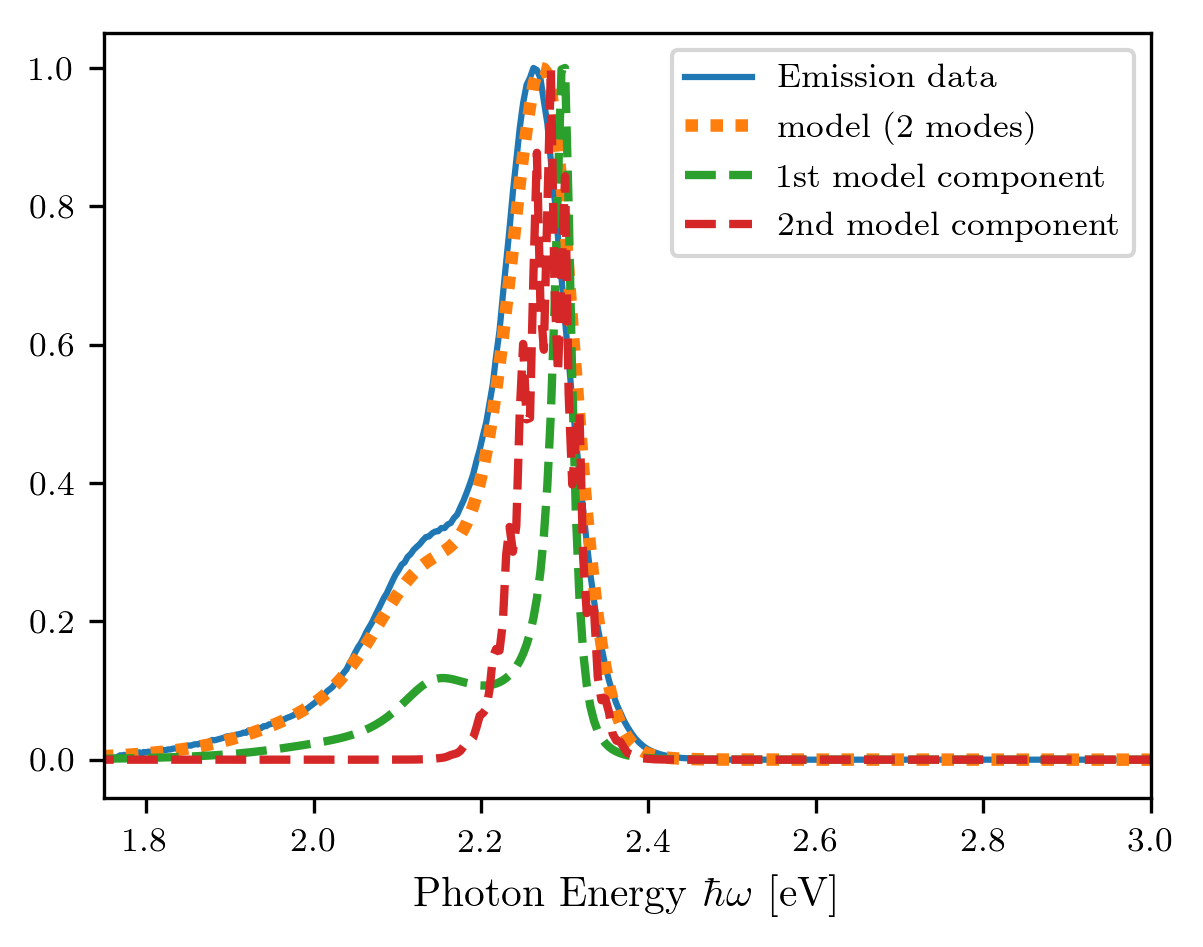

In [8]:
test_model_2_mode = dom.mol_fluo_model(
    num_vib_modes=2,
    hbar_omega_eg_0=2.3,
    script_d=[.9, 1.6],
    hbar_omega_0=[.17, .017],
    hbar_gamma=[.1, .001],
    T=300,)

model_2_mode = test_model_2_mode.emission_lineshape(
    hbar_omegas/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 10000)

model_1st_mode = test_model_2_mode.emission_lineshape(
    hbar_omegas/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 10000)

model_2nd_mode = test_model_2_mode.emission_lineshape(
    hbar_omegas/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 10000)


plt.plot(
    1240/thermo_fisher_dye_data.T[0], 
    norm_spec(nm_to_ev_correct(thermo_fisher_dye_data.T[2])), 
    label='Emission data')

plt.plot(hbar_omegas, norm_spec(model_2_mode), ls=(0, (1, 1)), lw=3, label='model (2 modes)')
plt.plot(hbar_omegas, norm_spec(model_1st_mode), ls='--', lw=2, label='1st model component')
plt.plot(hbar_omegas, norm_spec(model_2nd_mode), ls='--', lw=2, label='2nd model component')

plt.legend()
plt.xlim([1.75, 3])
plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)

In [9]:
def model_from_params(params, num_modes):
    return dom.mol_fluo_model(
        num_vib_modes=num_modes,
        hbar_omega_eg_0=float(params[0]),
        script_d=params[2+2*num_modes: 2+3*num_modes],
        hbar_omega_0=params[2: 2+1*num_modes],
        hbar_gamma=params[2+1*num_modes: 2+2*num_modes],
        T=params[1],)

def muk_mol_fit_fun(params, *args):
    """ Try naive fit function with fixed integration differential size
        and bound.

        Params: (list of fit parameters) Should be list of 
            2 + (3*num_modes) containing the following model parameters;
            ~~~~~~~~~~~~~~~~
            [0] hbar_omega_eg_0: the difference in zero point energy of 
                the vibrational oscillators between the two electronic
                states (eV).
                
            [1] T: temperature 
            
            [2:2+num_modes] hbar_omega_0: vibrational ressonance energy 
                in eV.
                
            [2+num_modes:2+2*num_modes] hbar_gamma: damping rate from 
                solvent or etc.
                
            [2+2*num_modes: 2+3*num_modes]script_d: unitless 
                displacement of the vibronic potential surface between
                electronic states.

        Args: (list of x axis and data)
        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            hbar_omega:
            data:
            num_modes:
        """
#     print(f'params:{params}, args:{args}')
    ## Define params and args with meaningful names
#     hbar_omega_eg_0, T, hbar_omega_0, hbar_gamma, script_d, = params
    ## params are ordered by 
    hbar_omegas, data, num_modes, t_bound, t_points, norm = args

    model_instance = model_from_params(params, num_modes)
    
    model = model_instance.emission_lineshape(
        hbar_omegas/hbar,
        t_bound=t_bound,
        t_points=t_points,)

    ## Normalize model and data
    model = model / np.max(model)
    data = data / np.max(data)

    return model - data

In [10]:
#     num_vib_modes=2,
#     hbar_omega_eg_0=2.3,
#     script_d=[.9, 1.6],
#     hbar_omega_0=[.17, .017],
#     hbar_gamma=[.1, .001],
#     T=300,)

ini_hbar_omega_eg_0 = 2.3
ini_script_d = [.9, 1.6]
ini_hbar_omega_0 = [0.17, .017]
ini_hbar_gamma = [.1, .001]
ini_T = 300

fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_T,
    *ini_hbar_omega_0,
    *ini_hbar_gamma,
    *ini_script_d,
    ])

hbar_omegas_arg = hbar_omegas
data_arg = nm_to_ev_correct(thermo_fisher_dye_data.T[2])
num_modes_arg = 2
t_bound_arg = 1000
t_points_arg = 1000
norm_arg = True

fit_args = (
    hbar_omegas_arg,
    data_arg,
    num_modes_arg,
    t_bound_arg,
    t_points_arg,
    norm_arg,
    )

model_fit = opt.least_squares(
    muk_mol_fit_fun,
    x0=fit_ini_guess,
    args=fit_args,
    bounds=(0, np.inf)
    )

In [11]:
model_fit['x']

array([2.29476253e+00, 3.01740301e+02, 1.56721053e-01, 7.51200990e-03,
       7.85564482e-02, 8.15656419e-01, 9.35349986e-01, 2.44132026e+00])

In [12]:
fit_ini_guess

array([2.3e+00, 3.0e+02, 1.7e-01, 1.7e-02, 1.0e-01, 1.0e-03, 9.0e-01,
       1.6e+00])

Text(0, 0.5, 'Normalized Emission Probability')

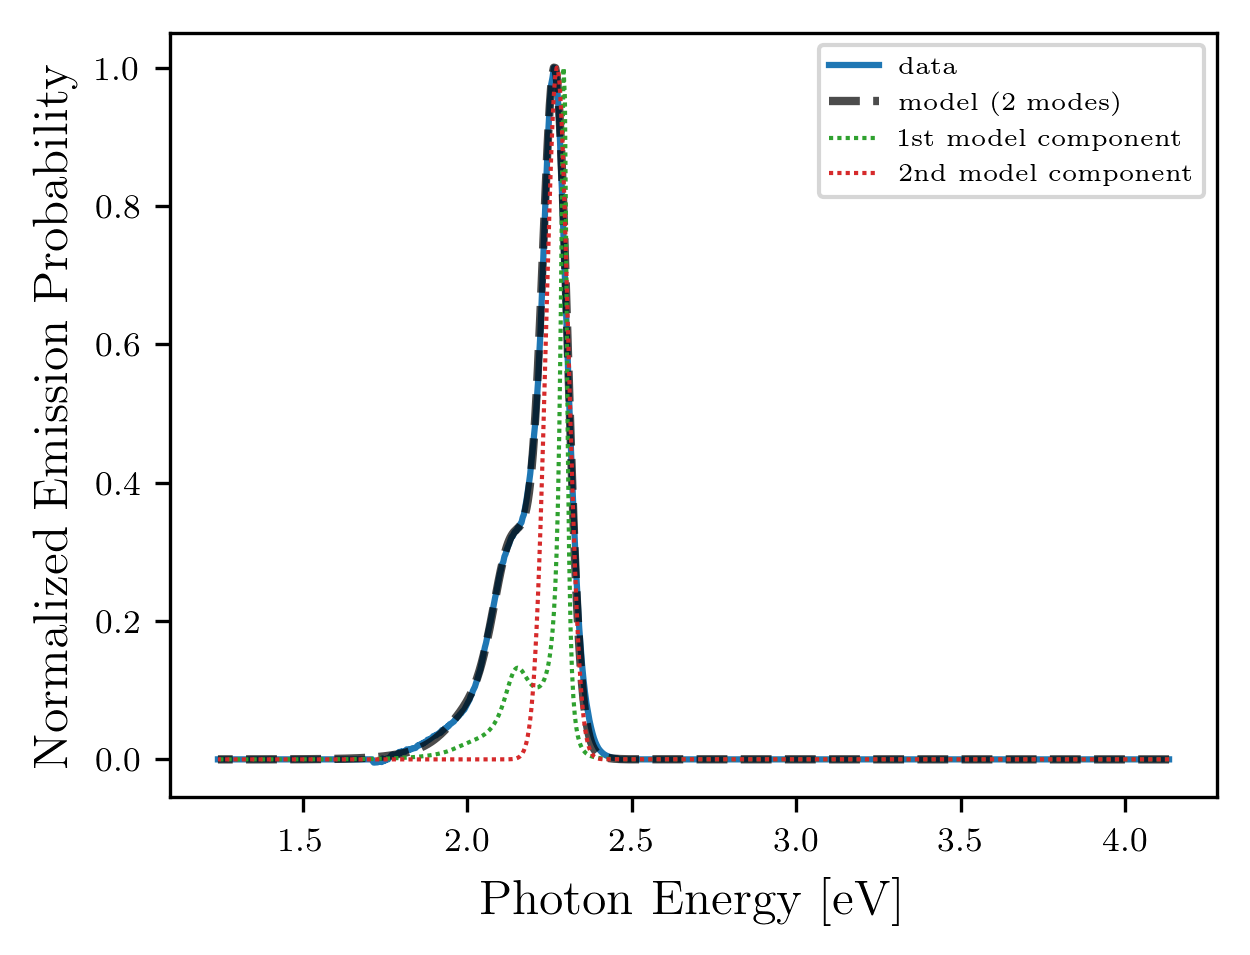

In [20]:
model_fit_inst = model_from_params(model_fit['x'], 2)

model_2_mode = model_fit_inst.emission_lineshape(
    hbar_omegas/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 1000)

model_1st_mode = model_fit_inst.emission_lineshape(
    hbar_omegas/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    hbar_omegas/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 1000)

plt.plot(hbar_omegas, norm_spec(data_arg), label='data')

plt.plot(hbar_omegas, norm_spec(model_2_mode), ls='--', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(hbar_omegas, norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.99, label='1st model component')
plt.plot(hbar_omegas, norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.99, label='2nd model component')
plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')


(1.7, 2.7)

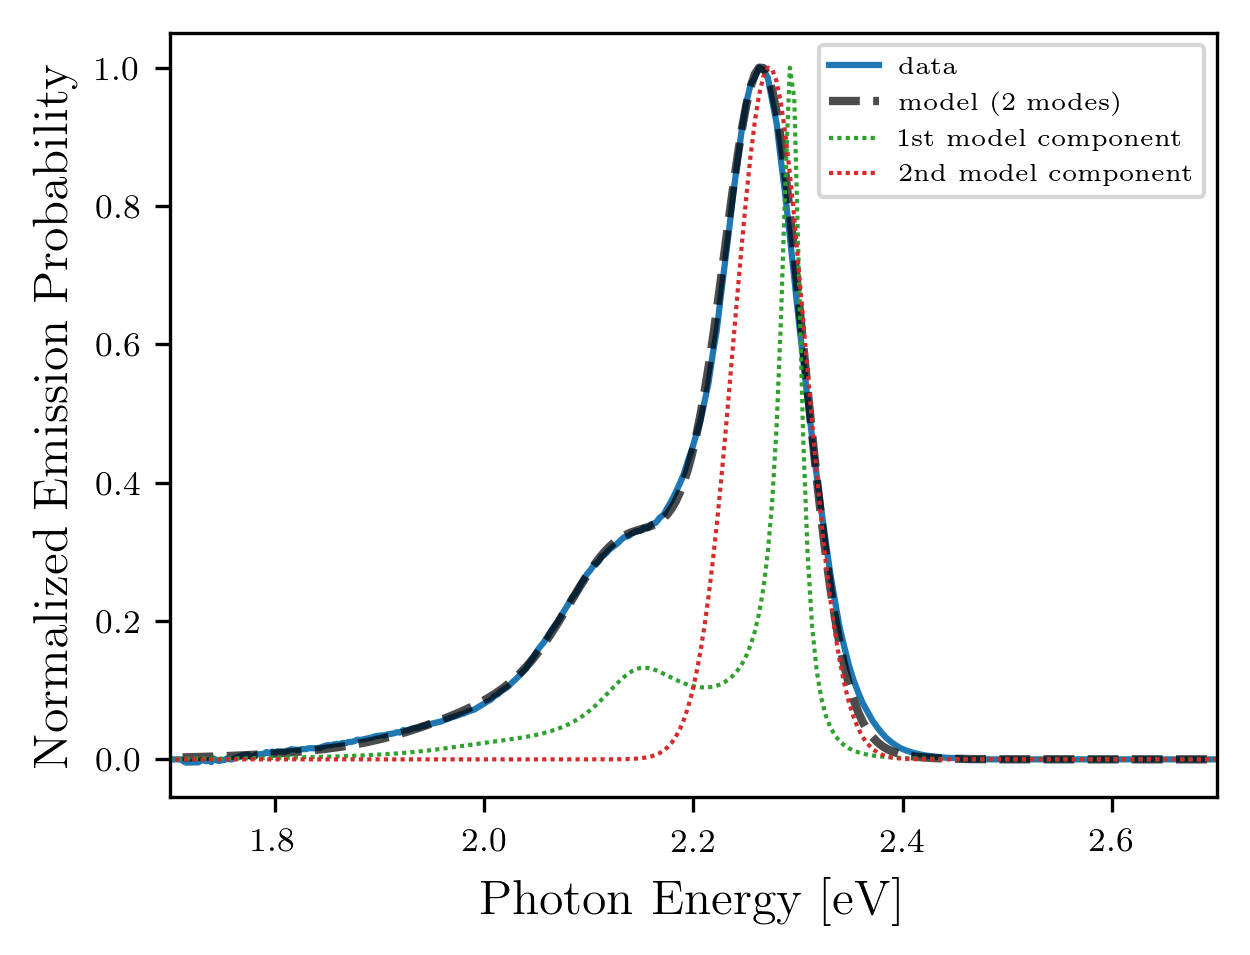

In [22]:
model_fit_inst = model_from_params(model_fit['x'], 2)

model_2_mode = model_fit_inst.emission_lineshape(
    hbar_omegas/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 1000)

model_1st_mode = model_fit_inst.emission_lineshape(
    hbar_omegas/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    hbar_omegas/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 1000)

plt.plot(hbar_omegas, norm_spec(data_arg), label='data')

plt.plot(hbar_omegas, norm_spec(model_2_mode), ls='--', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(hbar_omegas, norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.99, label='1st model component')
plt.plot(hbar_omegas, norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.99, label='2nd model component')
plt.legend(fontsize=6)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')
plt.xlim([1.7, 2.7])